### To use lompe almost in automatic mode

Reproducing Figure 6 and Figure 7 of the lompe paper (https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2022JA030356)

This assumes you already downloaded gridded superDARN data from https://zenodo.org/record/3618607#.YD4KiXVKiEJ.

You give the event date in `YYYY-MM-DD` format, supermag, ampere iridium and superdarn data will be downloaded cleaned and formated to be compatible with lompe package. Then in one of the cells in this notebook you can change the time and run duration, these are the only input needed here in addition to specifyin the grid.

In [1]:
from lompe.data_tools import dataloader, datadownloader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import lompe
import apexpy

Specifying the grid 

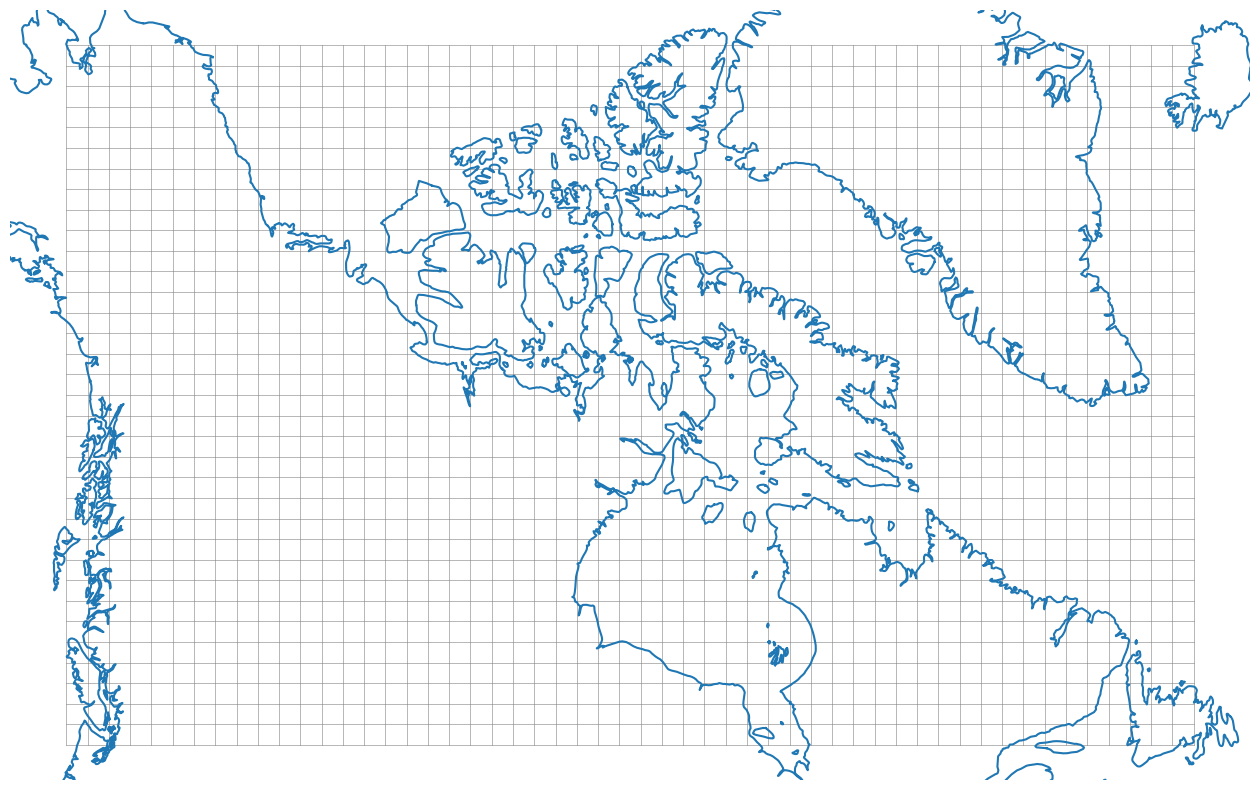

In [2]:
# cubed sphere grid parameters:
position = (-90, 68)  # lon, lat for grid center
orientation = 0       # angle of grid x axis - anti-clockwise from east direction
L, W = 7000e3, 3800e3 # extents [m] of grid
dL, dW = 100e3, 100e3 # spatial resolution [m] of grid 

# create grid object
grid = lompe.cs.CSgrid(lompe.cs.CSprojection(position, orientation), L, W, dL, dW, R = 6481.2e3)

# plot grid and coastlines
fig, ax = plt.subplots(figsize = (16, 10))
ax.set_axis_off()
for lon, lat in grid.get_grid_boundaries():
    xi, eta = grid.projection.geo2cube(lon, lat)
    ax.plot(xi, eta, color = 'grey', linewidth = .4)

xlim, ylim = ax.get_xlim(), ax.get_ylim()
for cl in grid.projection.get_projected_coastlines():
    ax.plot(cl[0], cl[1], color = 'C0')
    
ax.set_xlim(xlim)
ax.set_ylim(ylim);

**Preparing the data for the event (input data)**

In [9]:
# downlaod the data for the event (specifically iridium, supermag and superdarn data)
event = '2012-04-05' # you can change this to any date you want to analyze
# reading files if they exist or downloading and preparing in lompe data formats 
sdarn_file = datadownloader.download_sdarn(event, tempfile_path='./sample_dataset/')
smag_file = datadownloader.download_supermag(event, tempfile_path='./sample_dataset/')
iridium_file = datadownloader.download_iridium(event, tempfile_path='./sample_dataset/')
file_iridium = dataloader.read_iridium(event,file_name=iridium_file, tempfile_path='./sample_dataset/')
# file names and location, reading the data 
supermag  = pd.read_hdf(smag_file)
superdarn = pd.read_hdf(sdarn_file) 
iridium   = pd.read_hdf(file_iridium)

In [10]:
# function to fecth data subsets based on start and end time
def get_data_subsets(t0, t1):
    """ return subsets of data loaded above, between t0 and t1 """
    
    # Iridium data:
    irid = iridium[(iridium.time >= t0) & (iridium.time <= t1)]
    irid_B = np.vstack((irid.B_e.values, irid.B_n.values, irid.B_r.values))
    irid_coords = np.vstack((irid.lon.values, irid.lat.values, irid.r.values))

    # SuperMAG data:
    smag = supermag.loc[t0:t1, :]
    smag_B = np.vstack((smag.Be.values, smag.Bn.values, smag.Bu.values))
    smag_coords = np.vstack((smag.lon.values, smag.lat.values))
    
    # SuperDARN data:
    sd = superdarn.loc[t0:t1, :]
    vlos = sd['vlos'].values
    sd_coords = np.vstack((sd['glon'].values, sd['glat'].values))
    los  = np.vstack((sd['le'].values, sd['ln'].values))

    
    # Make the data objects. The scale keyword determines a weight for the dataset. Increase it to reduce weight
    # 'scale' keyword deprecated as of June 2023 in favor of 'error' and 'iweight' keywords
    #iridium_data   = lompe.Data(irid_B * 1e-9, irid_coords,            datatype = 'space_mag_fac', scale = 200e-9)
    #supermag_data  = lompe.Data(smag_B * 1e-9, smag_coords,            datatype = 'ground_mag'   , scale = 100e-9)
    #superdarn_data = lompe.Data(vlos         , sd_coords  , LOS = los, datatype = 'convection'   , scale = 500 )
    
    iridium_data   = lompe.Data(irid_B * 1e-9, irid_coords,            datatype = 'space_mag_fac', iweight = 1.0, error = 30e-9)
    supermag_data  = lompe.Data(smag_B * 1e-9, smag_coords,            datatype = 'ground_mag'   , iweight = 0.4, error = 10e-9)
    superdarn_data = lompe.Data(vlos         , sd_coords  , LOS = los, datatype = 'convection'   , iweight = 1.0, error = 50 )

    return(iridium_data, supermag_data, superdarn_data)

**Set up model and run inversion**

For the conductance, we will have two options for now the Hardy model or Zhang-Paxton model with Kp=4 (for example here), in addition to solar EUV.



ground_mag: Measurement uncertainty effectively changed from 1e-08 to 1.5811388300841896e-08


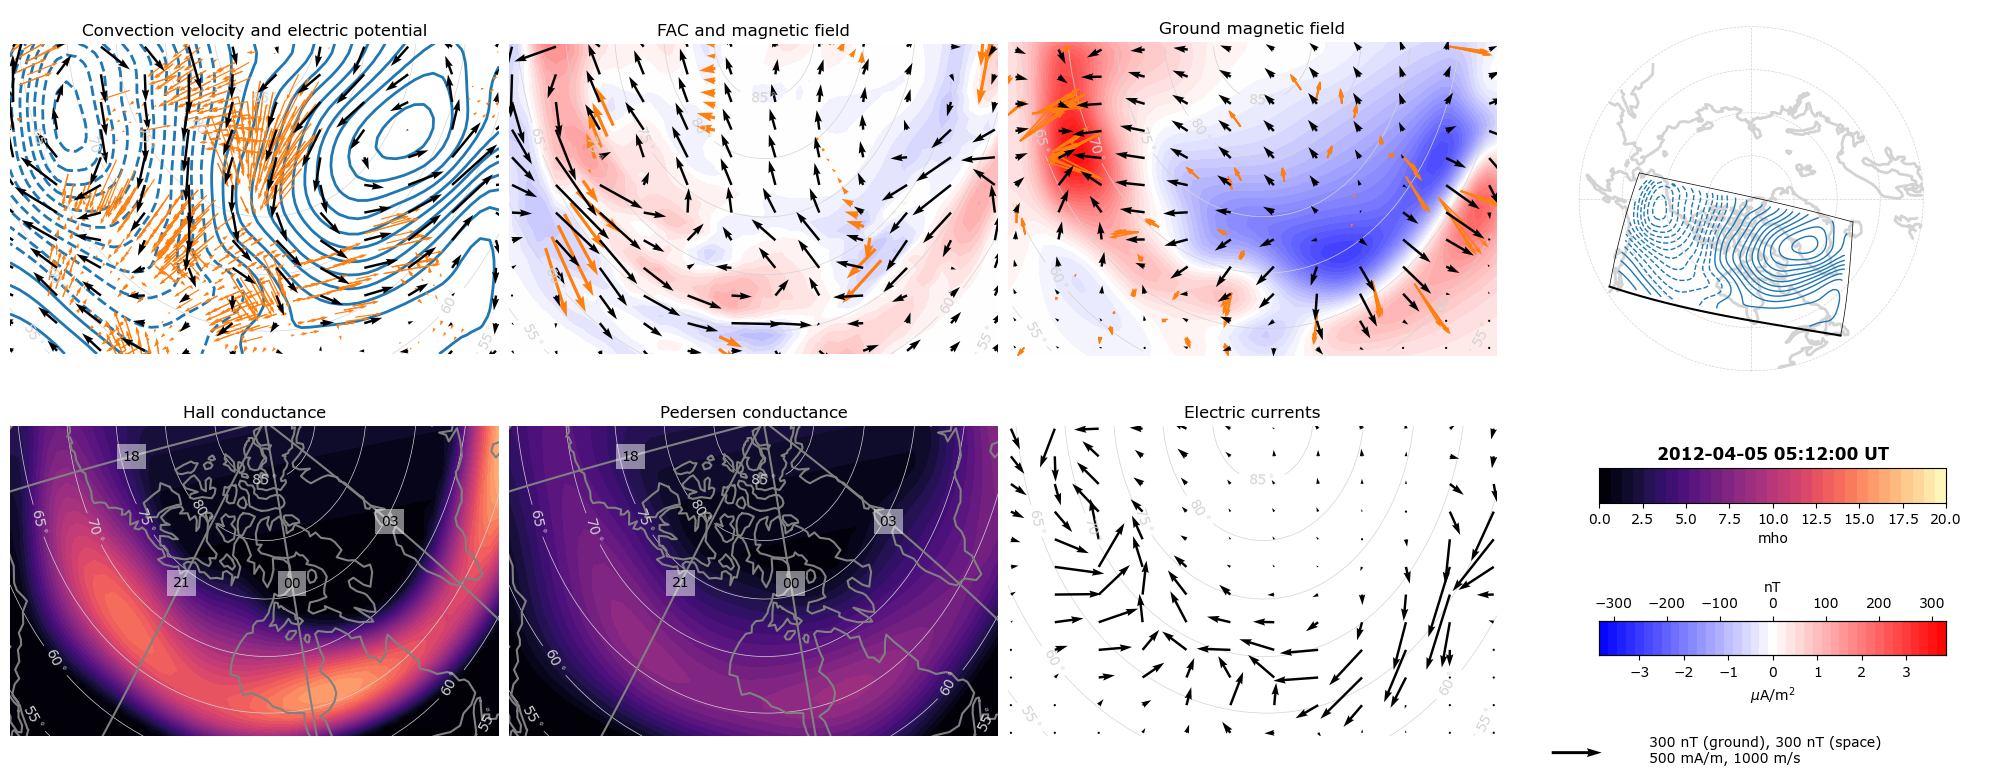

In [11]:
# time to plot for (you can chnage the time here, manually :) )
date_str = event + 'T' + '5:12:00'
T0 = dt.datetime.strptime(date_str, '%Y-%m-%dT%H:%M:%S')
DT = dt.timedelta(seconds = 60 * 4) # length of time interval

# apex object for plotting in magnetic
apex = apexpy.Apex(T0, refh = 110)
# making conductance tuples
Kp = 4 # this is the input to the Hardy model
SH = lambda lon = grid.lon, lat = grid.lat: lompe.conductance.hardy_EUV(lon, lat, Kp, T0, 'hall')
SP = lambda lon = grid.lon, lat = grid.lat: lompe.conductance.hardy_EUV(lon, lat, Kp, T0, 'pedersen')

# Create Emodel object. Pass grid and Hall/Pedersen conductance functions
model = lompe.Emodel(grid, Hall_Pedersen_conductance = (SH, SP))

# add datasets to model
iridium_data, supermag_data, superdarn_data = get_data_subsets(T0 - DT/2, T0 + DT/2) # data from new model time
model.add_data(iridium_data, supermag_data, superdarn_data)

# Run inversion. l1 and l2 are regularization parameters that control the damping of 
# 1) model norm, and 2) gradient of SECS amplitudes (charges) in magnetic eastward direction
model.run_inversion(l1 = 1, l2 = 10)

# finally, plot (plot is saved as specified path):
fig = lompe.lompeplot(model, include_data = True, time = T0, apex = apex)#, savekw = {'fname':'./output_figures/north_america.pdf'})

Below is an example showing a case where superdarn data is only used, to see how teh model ouput changes when there is a varying sources of input data

The provided iweights were re-scaled so max(iweights)=1


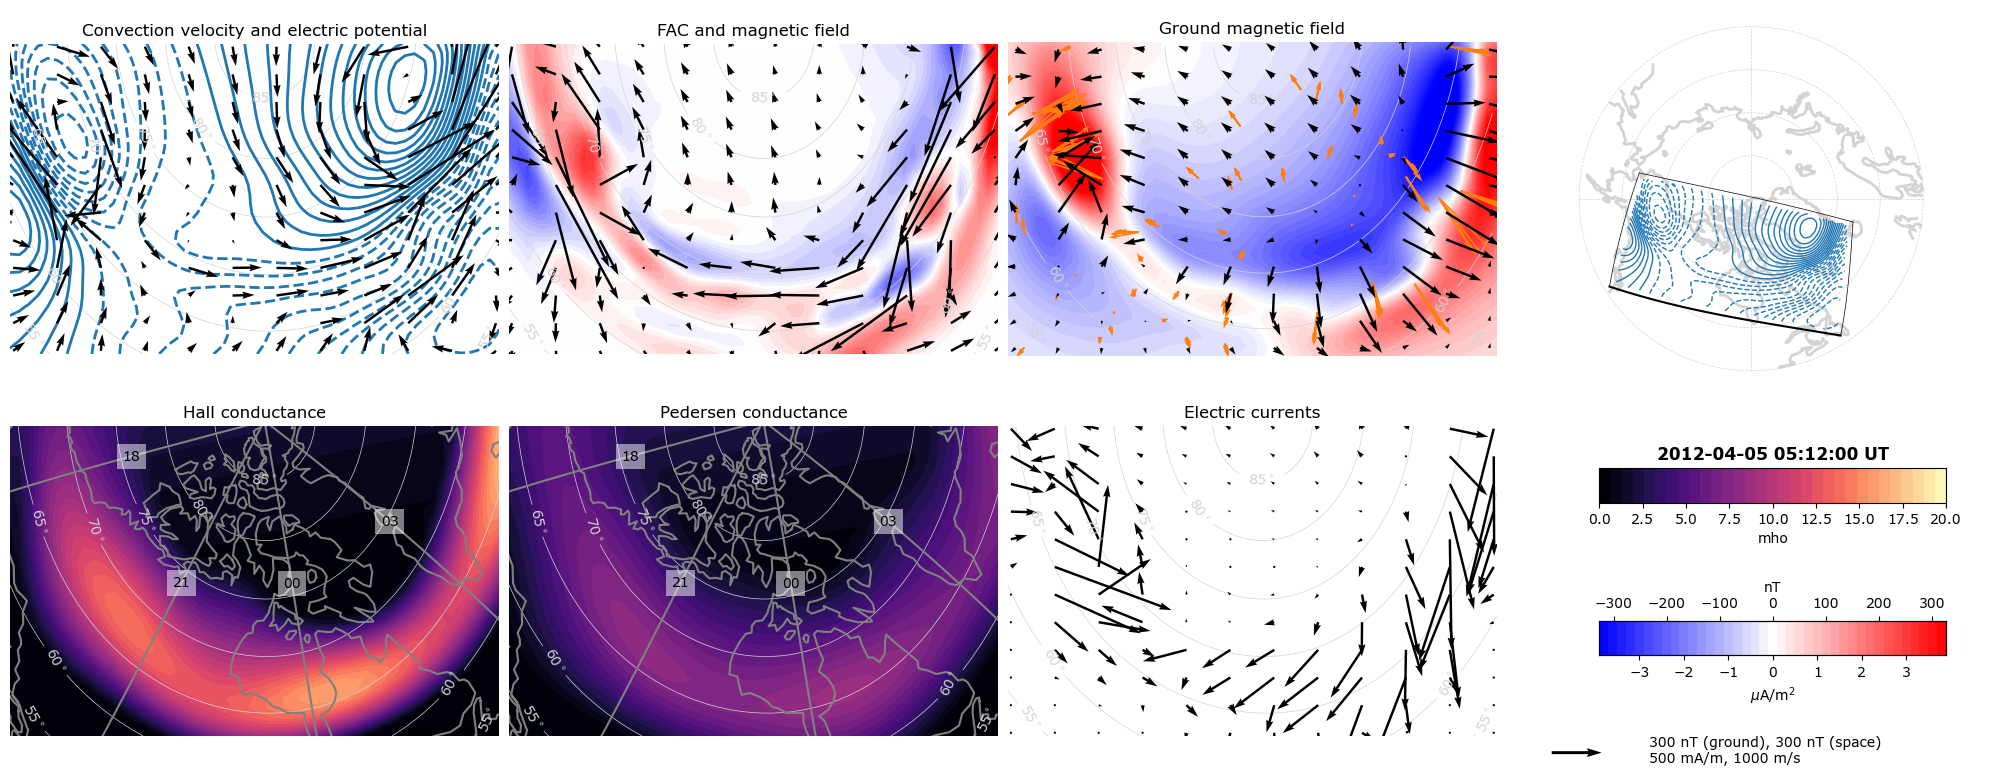

In [12]:
# clear model and pass conductances
model.clear_model(Hall_Pedersen_conductance = (SH, SP))

################
# Here you can experiment with adding only some of the datasets to the model by changing which lines are comments:

#model.add_data(iridium_data)
model.add_data(supermag_data)
# model.add_data(superdarn_data)

################

# Run inversion. l1 and l2 are regularization parameters that control the damping of 
# 1) model norm, and 2) gradient of SECS amplitudes (charges) in magnetic eastward direction
model.run_inversion(l1 = 1, l2 = 10)

# Finally, plot:
fig = lompe.lompeplot(model, include_data = True, time = T0, apex = apex)